<a href="https://colab.research.google.com/github/ankur2392roy/Avian_Flu_outbreak__-Machine-Learning-approach/blob/master/avian_flu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<H1> Predicting Avian Flu Outbreaks </H1>
<H3> Authors: Amberle McKee and Ankur Roy </H3>
<H3> Completion Date: July 2023 </H3>



> Note: Each time you run this notebook, you will be pulling the latest infection data from the USDA.



<H2> Goal </H2>

The goal of this project is to predict imminent avian flu outbreaks using positive infection data from the USDA found [here](https://www.aphis.usda.gov/aphis/ourfocus/animalhealth/animal-disease-information/avian/avian-influenza/hpai-2022/2022-hpai-wild-birds).

<H2> Methods </H2>

In this project, we first cleaned the dataset by consolidating different spelling variations of the virus strains and separating out the month, week, and year. We then plotted the data in many different ways to develop an intuition about the existing data. We defined an epidemic as being in the upper quantile of infection counts per day.

We used three machine learning models to investigate avian flu epidemics, Support Vector Machines (SVM), Random Forest, and Logistic Regression. Each of these models investigates different aspects of our dataset.

The SVM model was used to predict whether an epidemic is imminent based on the most recent infection counts. The probability that the most recent positive infection will be part of an epidemic is provided from this model. Additionally, the coeffiecients used in this model give us insight into the importance of each feature to that prediction. A table of the coefficients and support vectors for each feature is provided. As of the date of completion, the most important features were bird species and year.

The Random Forest Classifier approach helps us to classify and list the cases as either epidemic or not. The model trains itself on the training dataset and on applying to the test dataset, predicts the epidemic cases to an impressive degree which is measured by the relative error. The main parameter for the model is the number of estimators or trees that one would choose to employ. We did not opt to do hyperparameter tuning for this model as well as the following since classification algorithms like random forest and logistic regression do a good job predicting results in the default configuration itself.

The Logistic Regression was used to predict binary output from the input features, namely 1 for avian flu epidemic and 0 for non-epidemic situation. The model will be particularly useful for making predictions in the future as new data is added to the source data and help to identify which features are more responsible for the spread of the epidemic.





<H1> Code and data logistics </H1>

<h3> Import the necessary libraries and modules. </h3>

In [ ]:
# Logistical libraries
import pandas as pd #For using tables and sheets
import os #For mounting data from google drive
import numpy as np #for numerical work
import requests #for pulling the data from the USDA webpage
import io # for standardizing inputs and outputs
from datetime import datetime # for handling dates more efficiently
import warnings #for specifying warnings that are unuseful
import math #for doing some basic math

# Plotting libraries
import matplotlib.pyplot as plt #for graphing
import matplotlib.dates as mdates #for modifying dates
import seaborn as sns #for plotting
from tabulate import tabulate #for making asthetically pleasing tables

# Machine Learning libraries
from sklearn import preprocessing # for preprocessing the data before modeling
from sklearn.model_selection import train_test_split # for splitting the data into training and testing sets
from sklearn.preprocessing import StandardScaler #for scaling the data for modeling
from sklearn.svm import SVC #for a classification svm model
from sklearn.ensemble import RandomForestClassifier # for the random forest classifier model
from sklearn.linear_model import LogisticRegression #for the logistic regression model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score #for evaluating the models
from sklearn.model_selection import GridSearchCV #for tuning hyperparameters with grid search
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve #for evaluating ml models visually
from sklearn.metrics import classification_report # for generating a classification report
from pandas import Series

<h3> Import the data from the USDA webpage. </h3>

In [ ]:
url = 'https://www.aphis.usda.gov/csv-data/hpai-wild-birds-ver2.csv'

response = requests.get(url)

# Check for any download errors
response.raise_for_status()

data = response.content.decode('utf-8')

influenza_df = pd.read_csv(io.StringIO(data))

influenza_df.head()



,State,County,Date Detected,HPAI Strain,Bird Species,WOAH Classification,Sampling Method,Submitting Agency
0,South Carolina,Colleton,01/13/2022,EA H5N1,American wigeon,Wild bird,Hunter harvest,NWDP
1,South Carolina,Colleton,01/13/2022,EA H5N1,Blue-winged teal,Wild bird,Hunter harvest,NWDP
2,North Carolina,Hyde,01/12/2022,EA H5N1,Northern shoveler,Wild bird,Hunter harvest,NWDP
3,North Carolina,Hyde,01/20/2022,EA H5N1,American wigeon,Wild bird,Hunter harvest,NWDP
4,North Carolina,Hyde,01/20/2022,EA H5,Gadwall,Wild bird,Hunter harvest,NWDP


<h3> Clean the data to standardize virus strains and dates. </h3>

Before diving straight into the analysis, we did some preliminary data
cleaning.  First of all, we got rid of any aliases in the HPAI Strain parameter column. We further reformatted the date by day, week and month to increase the number of important features that can be taken into consideration for our ML models.

In [ ]:
## Consolidating the different ways of writing the virus strains

# Training Data
influenza_df['HPAI Strain'] = influenza_df['HPAI Strain'].replace('EAH5', 'EA H5')
influenza_df['HPAI Strain'] = influenza_df['HPAI Strain'].replace('EA /AM H5N1', 'EA/AM H5N1')
influenza_df['HPAI Strain'] = influenza_df['HPAI Strain'].replace('EAAM H5N1', 'EA/AM H5N1')
influenza_df['HPAI Strain'] = influenza_df['HPAI Strain'].replace('EA H5EA/AM H5N1', 'EA/AM H5N1')

# Remove any rows with a Nan in the HPAI Strain column
influenza_df.dropna(subset=['HPAI Strain'], inplace=True)

virus_strains = influenza_df['HPAI Strain'].unique().tolist()
print("Virus strains: ", virus_strains)

Virus strains:  ['EA H5N1', 'EA H5', 'EA/AM H5N1', 'EA/AM H5', 'EA H5N5', 'EA H5 mixed', 'EA/AM H5N6']


In [ ]:
## Adding columns that parse out the date
influenza_df['Date_Detected']= pd.to_datetime(influenza_df['Date Detected'])
influenza_df['Month'] = influenza_df['Date_Detected'].dt.month_name().str[:3]
influenza_df['Year']=influenza_df['Date_Detected'].dt.year
influenza_df['Week']=influenza_df['Date_Detected'].dt.week

<ipython-input-4-486ec008752f>:5: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  influenza_df['Week']=influenza_df['Date_Detected'].dt.week


<h1> Data Visualizations </h1>

Before running any machine learning models, we thought it was imporatant to look at the raw data in several graphical formats. Below, you'll find several scatterplots and bar plots that help to give an overview of the data. This can help us to understand which regions and times have the highest avian flu cases as well as which virus strains are prevalent.

The box plot plots the virus infections per day. We used the upper quantile as our cutoff for an epidemic. This definition of epidemic is used later on in the machine learning models.

HPAI Strain                 EA H5  EA H5 mixed  EA H5N1  EA H5N5  EA/AM H5  \
Date Detected State                                                          
01/03/2023    Alabama         NaN          NaN      NaN      NaN       NaN   
              California      NaN          NaN      NaN      NaN       NaN   
              New York        NaN          NaN      1.0      NaN       NaN   
              Oregon          NaN          NaN      2.0      NaN       NaN   
              Pennsylvania    NaN          NaN      NaN      NaN       NaN   

HPAI Strain                 EA/AM H5N1  EA/AM H5N6  
Date Detected State                                 
01/03/2023    Alabama              1.0         NaN  
              California           4.0         NaN  
              New York             7.0         NaN  
              Oregon               NaN         NaN  
              Pennsylvania         1.0         NaN  


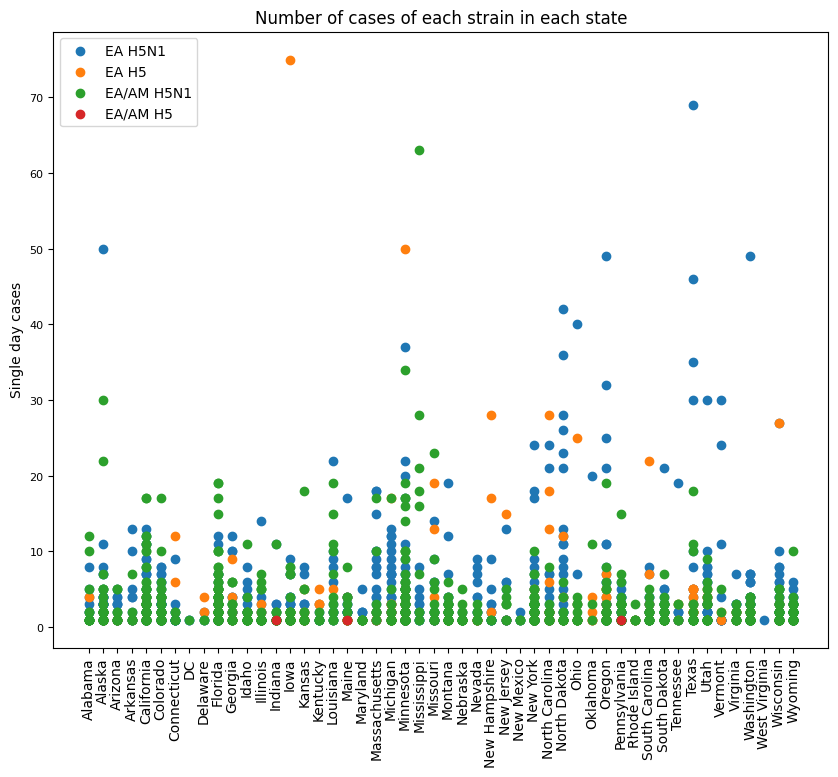

In [ ]:
## Create a simple chart showing the different strains detected on different dates in each state

# Create a pivot table with separate columns for each HPAI Strain
pivot = influenza_df.pivot_table(index=['Date Detected', 'State'],
                       columns='HPAI Strain',
                       values='Submitting Agency',
                       aggfunc='count')

print(pivot.head())

# Sort the pivot table by state name
pivot = pivot.sort_index(level='State')

# Increase the figure size
fig, ax = plt.subplots(figsize=(10, 8))

# Make a scatterplot of the cases per state per day
plt.scatter(pivot.index.get_level_values('State'), pivot['EA H5N1'])
plt.scatter(pivot.index.get_level_values('State'), pivot['EA H5'])
plt.scatter(pivot.index.get_level_values('State'), pivot['EA/AM H5N1'])
plt.scatter(pivot.index.get_level_values('State'), pivot['EA/AM H5'])


# Add x-axis label rotation
plt.xticks(rotation=90)

# Adjust the y-axis tick labels
plt.yticks(fontsize=8)

# Add titles
plt.title('Number of cases of each strain in each state')
plt.ylabel('Single day cases')
plt.legend(['EA H5N1', 'EA H5', 'EA/AM H5N1', 'EA/AM H5'])

plt.show()


HPAI Strain    EA H5  EA H5 mixed  EA H5N1  EA H5N5  EA/AM H5  EA/AM H5N1  \
Date Detected                                                               
2023-01-03       NaN          NaN      NaN      NaN       NaN         1.0   
2023-01-03       NaN          NaN      NaN      NaN       NaN         4.0   
2023-01-03       NaN          NaN      1.0      NaN       NaN         7.0   
2023-01-03       NaN          NaN      2.0      NaN       NaN         NaN   
2023-01-03       NaN          NaN      NaN      NaN       NaN         1.0   

HPAI Strain    EA/AM H5N6  
Date Detected              
2023-01-03            NaN  
2023-01-03            NaN  
2023-01-03            NaN  
2023-01-03            NaN  
2023-01-03            NaN  


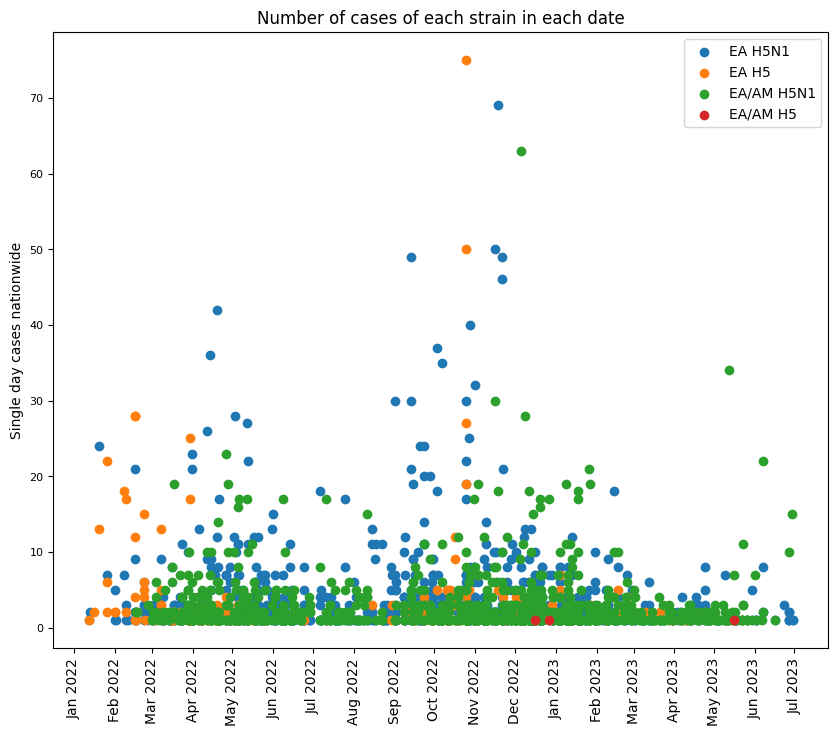

In [ ]:
## Create a simple chart showing the different strains detected on different dates nationwide

# Create a pivot table with separate columns for each HPAI Strain
pivot = influenza_df.pivot_table(index=['Date Detected', 'State'],
                       columns='HPAI Strain',
                       values='Submitting Agency',
                       aggfunc='count')

# Convert date format to datetime
pivot.index = pd.to_datetime(pivot.index.get_level_values('Date Detected'))

print(pivot.head())

# Sort the pivot table by date detected
pivot = pivot.sort_index(level='Date Detected')

# Increase the figure size
fig, ax = plt.subplots(figsize=(10, 8))

# Make a scatterplot of the cases per state per day
plt.scatter(pivot.index.get_level_values('Date Detected'), pivot['EA H5N1'])
plt.scatter(pivot.index.get_level_values('Date Detected'), pivot['EA H5'])
plt.scatter(pivot.index.get_level_values('Date Detected'), pivot['EA/AM H5N1'])
plt.scatter(pivot.index.get_level_values('Date Detected'), pivot['EA/AM H5'])


# Add x-axis label rotation
plt.xticks(rotation=90)

# Adjust the y-axis tick labels
plt.yticks(fontsize=8)

# Use MonthLocator and DateFormatter to set x-axis labels to show one label for the beginning of each month
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

# Add titles
plt.title('Number of cases of each strain in each date')
plt.ylabel('Single day cases nationwide')
plt.legend(['EA H5N1', 'EA H5', 'EA/AM H5N1', 'EA/AM H5'])

plt.show()

We'll define an epidemic as being in the top quantile of infection counts, or >=35 cases per day.


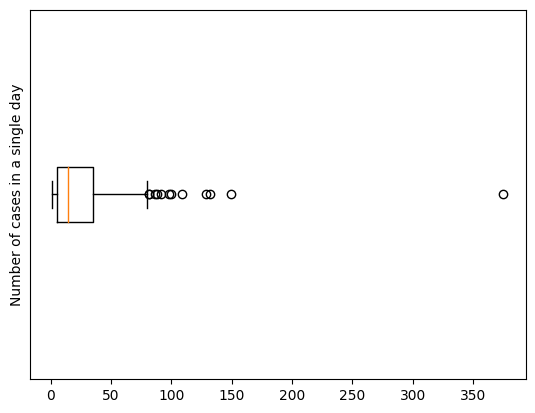

In [ ]:
#Making boxplots for number of cases in a single day
df_column=influenza_df.groupby('Date_Detected').count()
p=df_column['County'].values
plt.boxplot(p,vert=False)
plt.yticks([])
plt.ylabel('Number of cases in a single day')

q3=df_column['County'].quantile(0.75)
q1=df_column['County'].quantile(0.25)
iqr=q3-q1
upper_fence=q3+(1.5*iqr)
upper_fence
epidemic_dates=df_column[df_column['County'] > q3].index.tolist()
epidemic_dates=[i.date() for i in epidemic_dates]
epidemic_dates=[i.strftime('%Y-%m-%d') for i in epidemic_dates]
epidemic_dates=np.array(epidemic_dates)

print(f"We'll define an epidemic as being in the top quantile of infection counts, or >={round(q3)} cases per day.")

<h3> Adding a column defining an epidemic </h3>

We defined an epidemic as a day in which the infection rate is in the upper quantile of days. As of July 2023, this meant that any day in which there were >= 35 infected birds detected would be defined as an epidemic. Please note that because this is a dynamic notebook, this number may vary slightly every time it is run.

We added a column labeled "Epidemic" with a binary value for whether or not each detection (row) is part of an epidemic. This binary feature is what we will be using in the machine learning models below to attempt to predict whether a new case will be part of an epidemic.

In [ ]:
print(f"{q3} cases in one is the current definition of an epidemic.")


35.0 cases in one is the current definition of an epidemic.


In [ ]:
## Defining an epidemic as being in the upper quantile of infection rates
influenza_df['Epidemic']= influenza_df.groupby('Date Detected')['Date Detected'].transform('size').ge(round(q3)).astype(int)
influenza_df.head()

,State,County,Date Detected,HPAI Strain,Bird Species,WOAH Classification,Sampling Method,Submitting Agency,Date_Detected,Month,Year,Week,Epidemic
0,South Carolina,Colleton,01/13/2022,EA H5N1,American wigeon,Wild bird,Hunter harvest,NWDP,2022-01-13,Jan,2022,2,0
1,South Carolina,Colleton,01/13/2022,EA H5N1,Blue-winged teal,Wild bird,Hunter harvest,NWDP,2022-01-13,Jan,2022,2,0
2,North Carolina,Hyde,01/12/2022,EA H5N1,Northern shoveler,Wild bird,Hunter harvest,NWDP,2022-01-12,Jan,2022,2,0
3,North Carolina,Hyde,01/20/2022,EA H5N1,American wigeon,Wild bird,Hunter harvest,NWDP,2022-01-20,Jan,2022,3,1
4,North Carolina,Hyde,01/20/2022,EA H5,Gadwall,Wild bird,Hunter harvest,NWDP,2022-01-20,Jan,2022,3,1


               Infection Count
Bird Species                  
Mallard                    856
Canada goose               619
Black vulture              554
Snow goose                 526
Bald eagle                 467


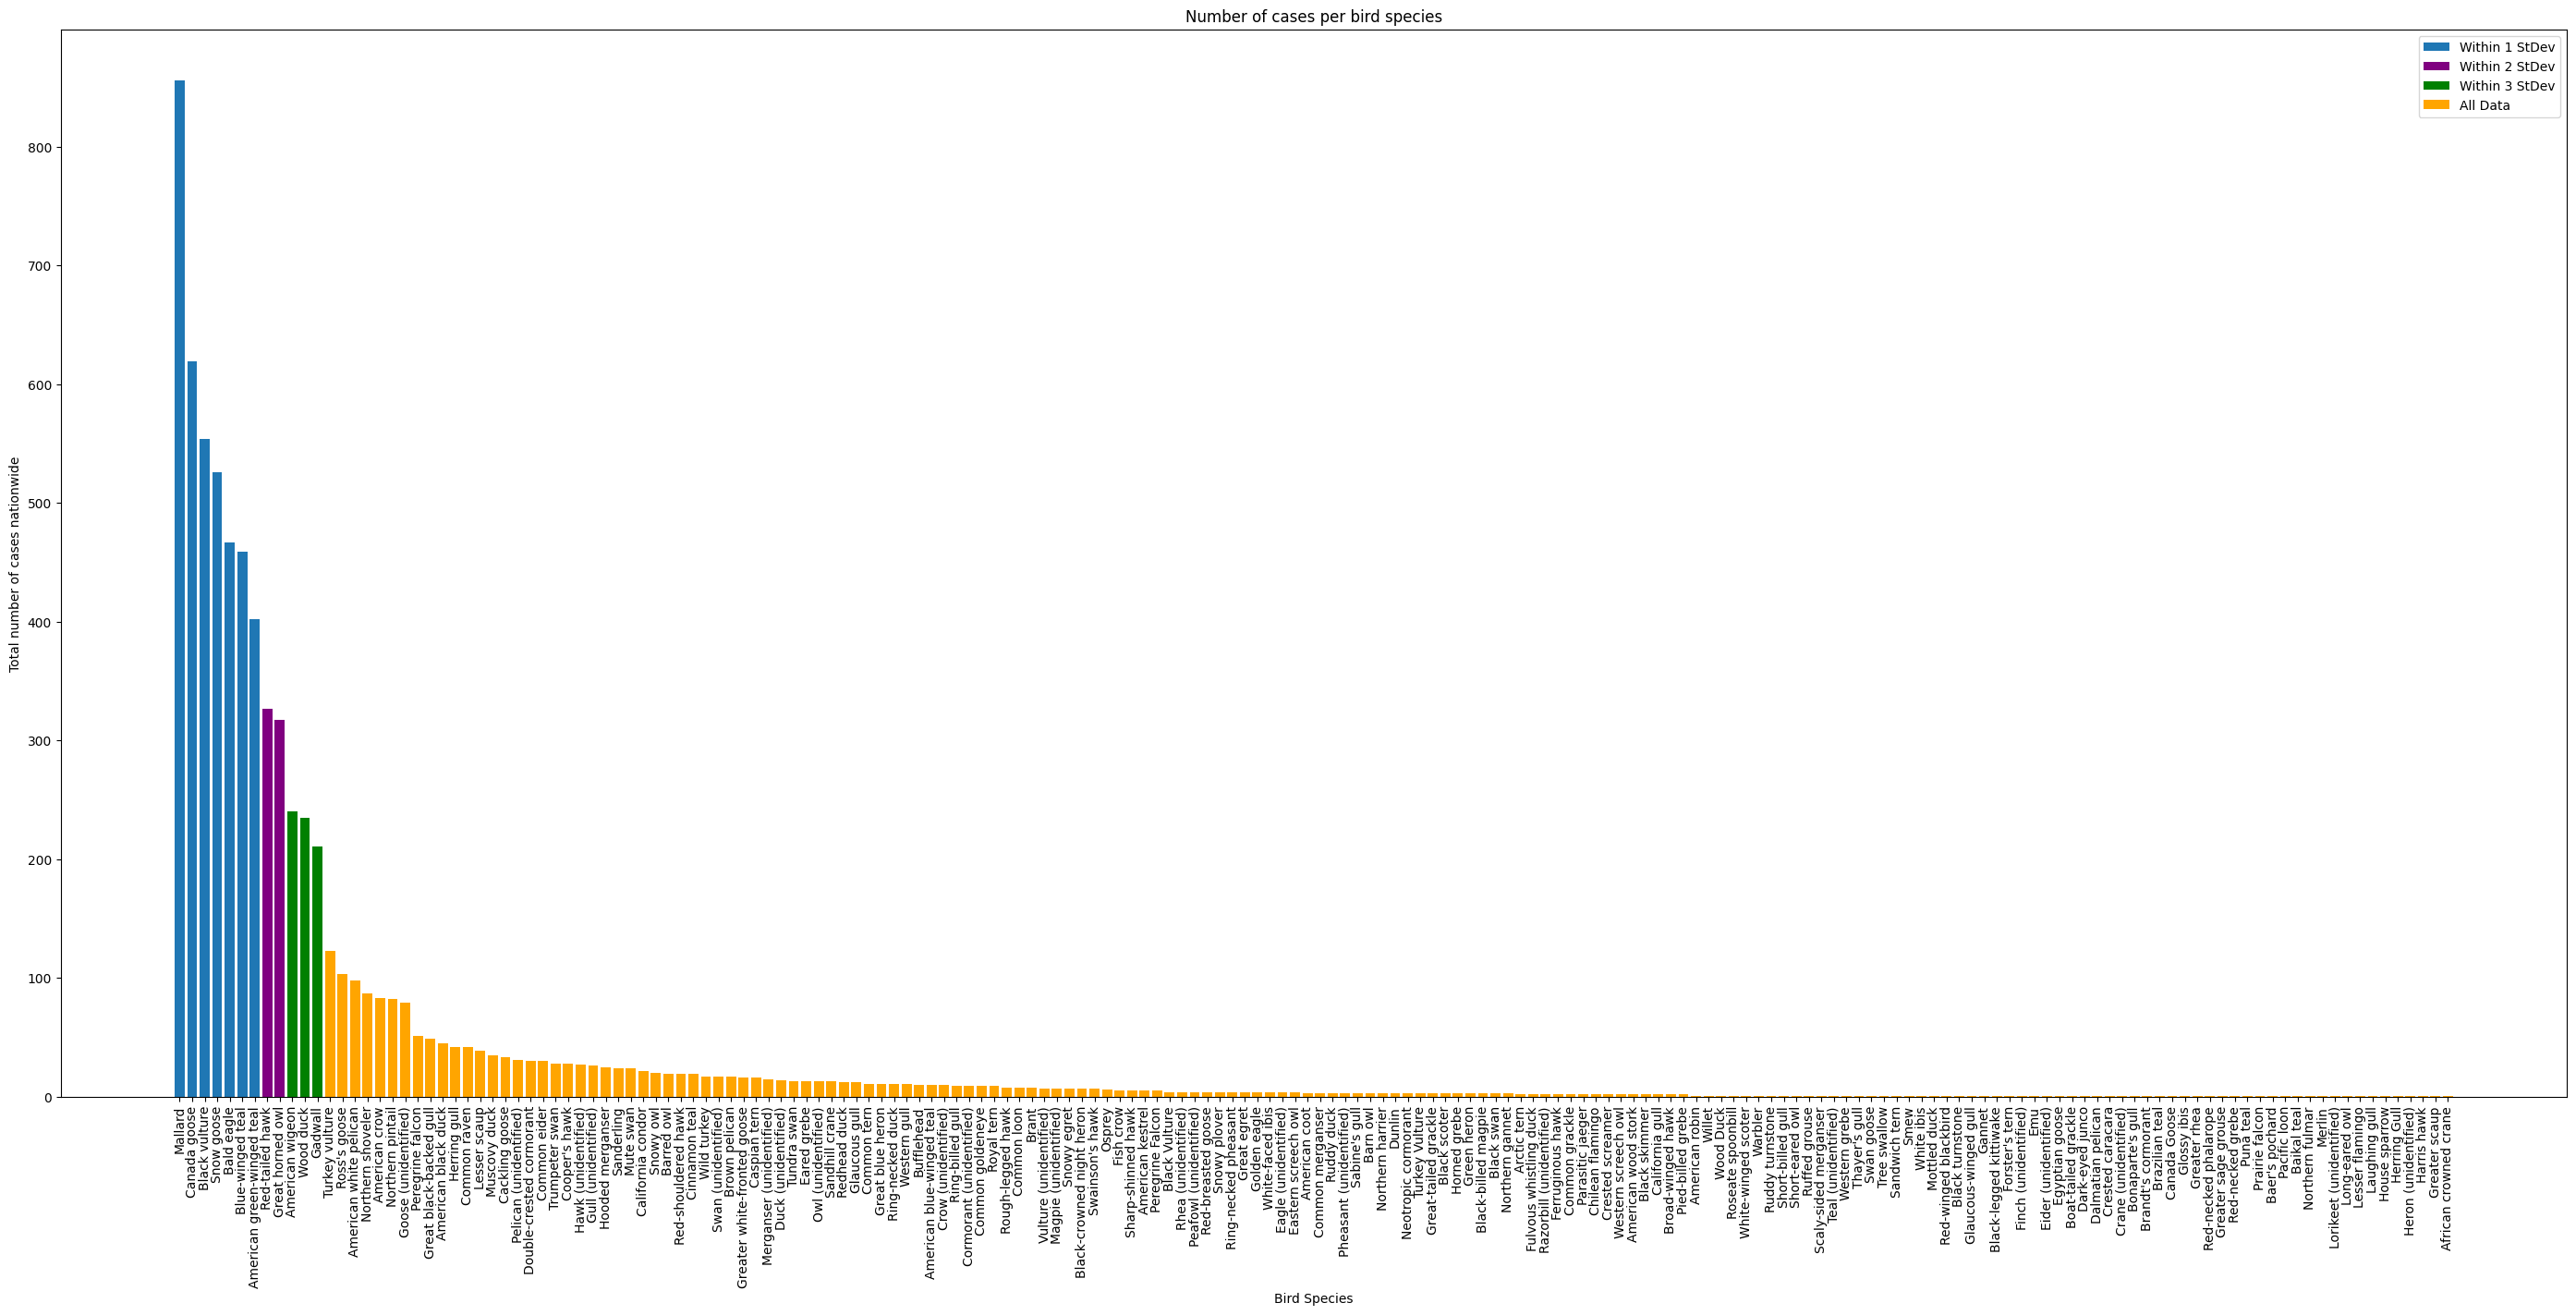

In [ ]:
## Create a simple chart showing the cases per species nationwide

# Create a pivot table with separate columns for each HPAI Strain
pivot = influenza_df.pivot_table(index=['Bird Species'],
                                 values='Submitting Agency',
                                 aggfunc='count')

# Rename the column heading
pivot = pivot.rename(columns={'Submitting Agency': 'Infection Count'})

# Sort the pivot table by case counts per species
pivot = pivot.sort_values(by='Infection Count', ascending=False)

print(pivot.head())

# Calculate mean and standard deviation
mean = pivot.sum(axis=1).mean()
std = pivot.sum(axis=1).std()

# Increase the figure size
fig, ax = plt.subplots(figsize=(35, 15))

# Plot the total number of cases for each species
plt.bar(pivot.index, pivot.sum(axis=1))

# Highlight species within 3 standard deviations of the mean
highlighted_species = pivot.index[(pivot.sum(axis=1) >= mean - 3 * std) & (pivot.sum(axis=1) <= mean + 3 * std)]
plt.bar(highlighted_species, pivot.loc[highlighted_species].sum(axis=1), color='purple')

# Highlight species within 2 standard deviations of the mean
highlighted_species = pivot.index[(pivot.sum(axis=1) >= mean - 2 * std) & (pivot.sum(axis=1) <= mean + 2 * std)]
plt.bar(highlighted_species, pivot.loc[highlighted_species].sum(axis=1), color='green')

# Highlight species within 1 standard deviation of the mean
highlighted_species = pivot.index[(pivot.sum(axis=1) >= mean - std) & (pivot.sum(axis=1) <= mean + std)]
plt.bar(highlighted_species, pivot.loc[highlighted_species].sum(axis=1), color='orange')

# Add x-axis label rotation
plt.xticks(rotation=90)

# Add titles
plt.title('Number of cases per bird species')
plt.xlabel('Bird Species')
plt.ylabel('Total number of cases nationwide')
plt.legend(['Within 1 StDev', 'Within 2 StDev', 'Within 3 StDev', 'All Data'])

plt.show()


50 50


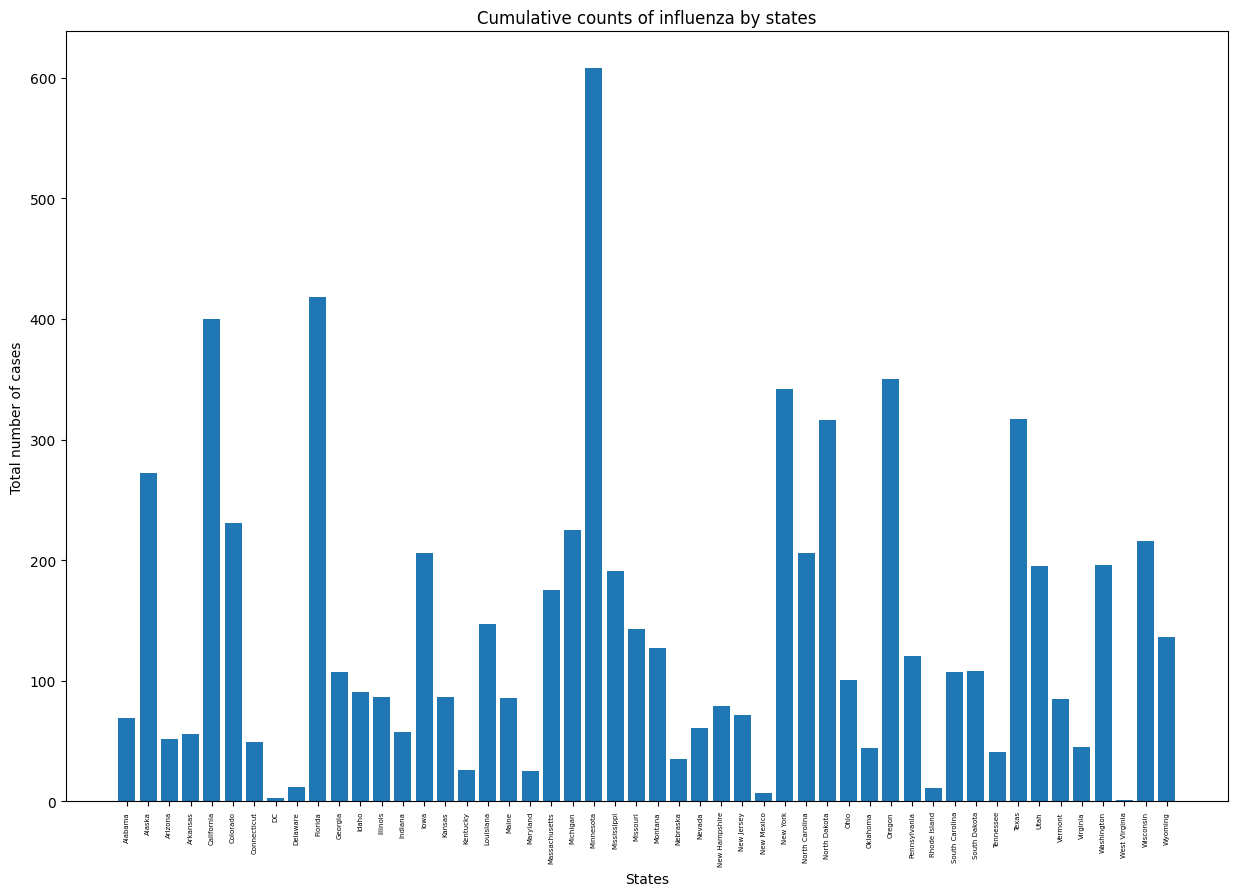

In [ ]:
## Create a simple chart of the cumulative infections by state

# Create a cumulative measure of infections for each state
states=sorted(influenza_df['State'].unique())
count_states=[]
for i in states:
  count=len(influenza_df[influenza_df['State']==i])
  count_states.append(count)

# Check for errors
print(len(states),len(count_states))

# Increase the figure size
fig, ax = plt.subplots(figsize=(15, 10))

# Create plot
plt.bar(states,count_states)
plt.xticks(states,rotation=90,size=5)
plt.xlabel('States')
plt.ylabel('Total number of cases')
plt.title('Cumulative counts of influenza by states')
plt.show()

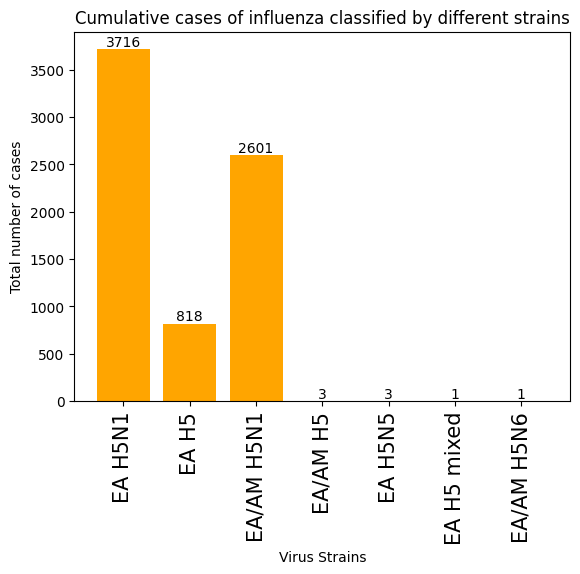

In [ ]:
## Create a simple chart showing the cumulative infections per virus strain

#Separate out each strain
influenza_strain = (influenza_df['HPAI Strain']).astype(str)
strains=influenza_strain.unique()

#Create a cumulative count of infections per strain
count_strains=[]
for i in strains:
  count=len(influenza_df[influenza_df['HPAI Strain']==i])
  count_strains.append(count)

count_strains=np.array(count_strains)

#Create chart
plt.bar(strains,count_strains,color='orange')
plt.xticks(strains,rotation=90,size=15)
plt.xlabel('Virus Strains')
plt.ylabel('Total number of cases')
plt.title('Cumulative cases of influenza classified by different strains')

# Add annotations to the top of each bar
for i, count in enumerate(count_strains):
    plt.text(i, count, str(count), ha='center', va='bottom', fontsize=10)

plt.show()

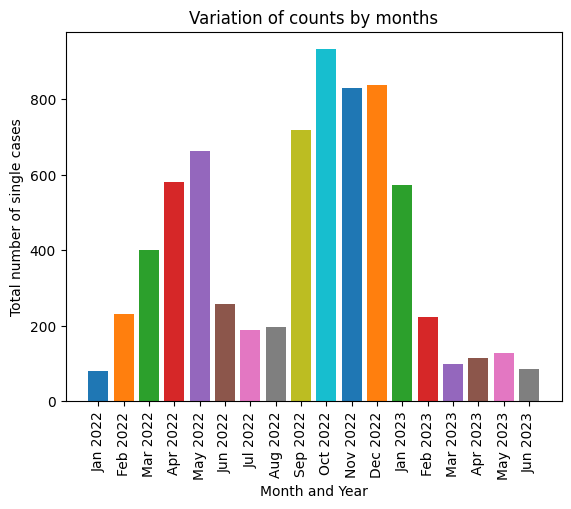

In [ ]:
#Create a graph of counts by week/month/year
influenza_df['Year'],influenza_df['Month'],influenza_df['Week']

#Check if there any nan values in the dataframe
influenza_df.isnull().values.any()
months=influenza_df['Month'].unique()
years=influenza_df['Year'].unique()

#Classifying by Month
for i in years:
  for j in months:
    string_t=j +' '+str(i)
    count_t=0
    for index, row in influenza_df.iterrows():
      if row[9]==j and row[10]==i:
        count_t=count_t+1


    if count_t > 0:
      plt.bar(string_t,count_t)
      plt.xticks(rotation=90,size=10)
    else:
      pass

plt.xlabel('Month and Year')
plt.ylabel('Total number of single cases')
plt.title('Variation of counts by months')
plt.show()

<h1> Data Modeling with Machine Learning </h1>

<h3> Preprocess the data to encode the objects and choose features. </h3>

We chose the specific features that we thought would be relevent to avian flu epidemics. Firstly, we know that region is important, so we included the columns for State and County in our analyses. Secondly, it is well-established that flu outbreaks occur seasonally, so we included the Week, Month, and Year columns in our analyses. Lastly, we propose that the virus strain and bird species may be important predictors of avian flu outbreaks, so we included the HPAI Strain and Bird Species columns in our analyses as well.

In [ ]:
#Model creation data
encoded_df=influenza_df.copy()

# Loop over each column in the DataFrame where dtype is 'object'
for col in encoded_df.select_dtypes(include=['object']).columns:

    # Initialize a LabelEncoder object
    label_encoder1 = preprocessing.LabelEncoder()
    # Fit the encoder to the unique values in the column
    label_encoder1.fit(encoded_df[col].unique())

    # Transform the column using the encoder
    encoded_df[col] = label_encoder1.transform(encoded_df[col])

encoded_df.drop('Date_Detected', axis=1, inplace=True)
encoded_df.head()

,State,County,Date Detected,HPAI Strain,Bird Species,WOAH Classification,Sampling Method,Submitting Agency,Month,Year,Week,Epidemic
0,39,167,8,2,9,2,2,67,4,2022,2,0
1,39,167,8,2,26,2,2,67,4,2022,2,0
2,32,324,6,2,115,2,2,67,4,2022,2,0
3,32,324,14,2,9,2,2,67,4,2022,3,1
4,32,324,14,0,72,2,2,67,4,2022,3,1


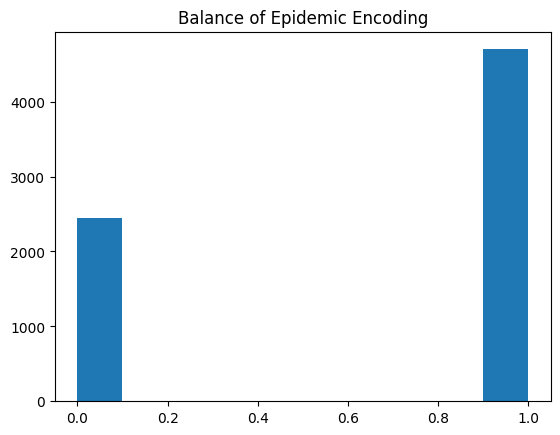

In [ ]:
plt.hist(encoded_df['Epidemic'])
plt.title('Balance of Epidemic Encoding')
plt.show()

 <h2> Support Vector Machines </h2>

In [ ]:
# Preparing the Data
X = encoded_df.drop(['Epidemic', 'Date Detected', 'WOAH Classification', 'Sampling Method', 'Submitting Agency'], axis=1)
y = encoded_df['Epidemic']

# Splitting the Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the parameter grid
param_grid = {
    'C': [1, 10],  # Reduced values for C
    'gamma': [0.1, 1]   # Reduced values for gamma
}

# Create the SVM model
svm = SVC(kernel='linear', probability=True)

# Perform grid search with cross-validation
grid_search = GridSearchCV(svm, param_grid, cv=10)
grid_search.fit(X_train_scaled, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Evaluate the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_scaled)

# Evalutation metrics
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print('Classification score report for SVC:\n',classification_report(y_test, y_pred) )

Best Hyperparameters: {'C': 1, 'gamma': 0.1}
Accuracy: 0.6774916013437849
Classification score report for SVC:
               precision    recall  f1-score   support

           0       0.51      0.26      0.34       583
           1       0.71      0.88      0.79      1203

    accuracy                           0.68      1786
   macro avg       0.61      0.57      0.56      1786
weighted avg       0.65      0.68      0.64      1786



In [ ]:
# Suppress the warning message about feature names
warnings.filterwarnings("ignore", message="X has feature names, but SVC was fitted without feature names")

probabilities = best_model.predict_proba(X.iloc[[-1]])
epidemic_probabilities = probabilities[:, 1]
print(f"The probability of the latest positive case being a part of an epidemic is {round(epidemic_probabilities[-1] * 100, 4)}%.")

The probability of the latest positive case being a part of an epidemic is 0.0%.


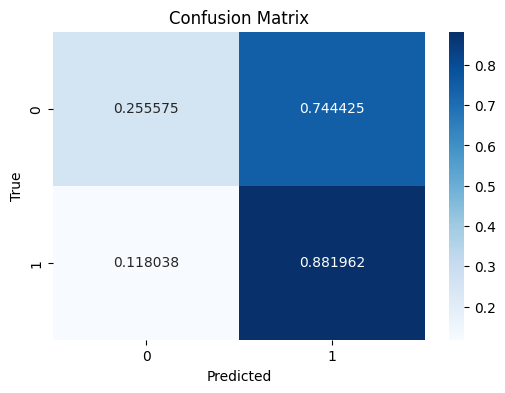

In [ ]:
## Visualizing the results of the SVM model

# Confusion Matrix
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Plot confusion matrix for test set
plot_confusion_matrix(y_test, y_pred)

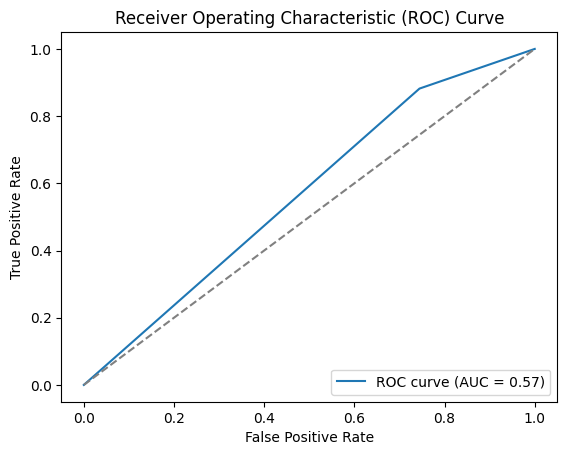

In [ ]:
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# Compute AUC score
auc_score = roc_auc_score(y_test, y_pred)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(auc_score))
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


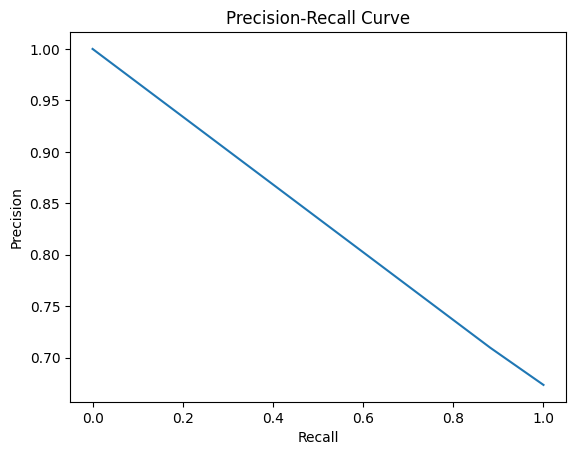

In [ ]:
# Compute precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)

# Plot precision-recall curve
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

In [ ]:
# Accessing support vectors
support_vectors = best_model.support_vectors_

# Accessing coefficients and features
coefficients = best_model.coef_.copy()
features = X.columns

# Create a list of pairs (feature, coefficient, support_vector)
pairs = [(feature, round(coefficient, 3 - int(math.floor(math.log10(abs(coefficient))))), support_vector) for feature, coefficient, support_vector in zip(features, coefficients[0], support_vectors)]

# Print the table
print(tabulate(pairs, headers=['Feature', 'Coefficient', 'Support Vector'], tablefmt='fancy_grid'))


# Calculate maximum and minimum coefficients and their corresponding features
max_index = coefficients[0].argmax()
min_index = coefficients[0].argmin()

max_feature = features[max_index]
min_feature = features[min_index]

max_coefficient = coefficients[0][max_index]
min_coefficient = coefficients[0][min_index]

print(f"{max_feature} has the largest positive coefficient, indicating the strongest positive influence on the epidemic prediction, while {min_feature} has the largest negative coefficient, indicating the strongest negative influence on the epidemic prediction.")


╒══════════════╤═══════════════╤══════════════════════════════════════════════════════════════════════════╕
│ Feature      │   Coefficient │ Support Vector                                                           │
╞══════════════╪═══════════════╪══════════════════════════════════════════════════════════════════════════╡
│ State        │     7.515e-05 │ [-1.42922523  1.14707338 -0.52400248 -1.28413477  1.35631374 -0.45953116 │
│              │               │   0.53053785]                                                            │
├──────────────┼───────────────┼──────────────────────────────────────────────────────────────────────────┤
│ County       │     1.998e-05 │ [-1.35895762  1.21323544 -0.52400248  1.17824276  0.25946916 -0.45953116 │
│              │               │  -1.015354  ]                                                            │
├──────────────┼───────────────┼──────────────────────────────────────────────────────────────────────────┤
│ HPAI Strain  │    -7.632e-

<h2> Random Forest </h2>

In [ ]:
# Here we describe our attempt at modeling with Random Forest

labels = np.array(encoded_df['Epidemic'])
features= encoded_df.drop(['Epidemic', 'Date Detected', 'WOAH Classification', 'Sampling Method', 'Submitting Agency'], axis=1)


train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)



Training Features Shape: (5357, 7)
Training Labels Shape: (5357,)
Testing Features Shape: (1786, 7)
Testing Labels Shape: (1786,)


In [ ]:

# Instantiate model with 1000 decision trees
rf = RandomForestClassifier(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(train_features, train_labels);

Week            0.398762
County          0.159322
Month           0.133330
State           0.132857
Bird Species    0.104071
HPAI Strain     0.037584
Year            0.034073
dtype: float64


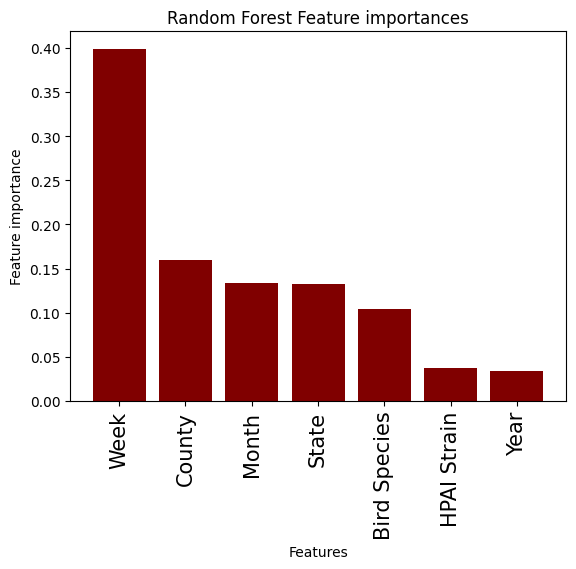

In [ ]:
#Finding the relative importance of differen features
#features.columns

feature_imp=pd.Series(rf.feature_importances_,index=train_features.columns).sort_values(ascending=False)
print(feature_imp)
plt.bar(feature_imp.index.values,feature_imp.to_numpy(),color='maroon')
plt.xticks(feature_imp.index.values,rotation=90,size=15)
plt.xlabel('Features')
plt.ylabel('Feature importance')
plt.title('Random Forest Feature importances')
plt.show()

In [ ]:
predictions = rf.predict(test_features)
print(test_labels,predictions)
errors = abs(predictions - test_labels)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2))

[1 1 1 ... 0 1 1] [1 1 1 ... 0 1 1]
Mean Absolute Error: 0.06


Accuracy score: 0.9406494960806271
Confusion matrix: [[ 509   74]
 [  32 1171]]
[[0.87307033 0.12692967]
 [0.02660017 0.97339983]]


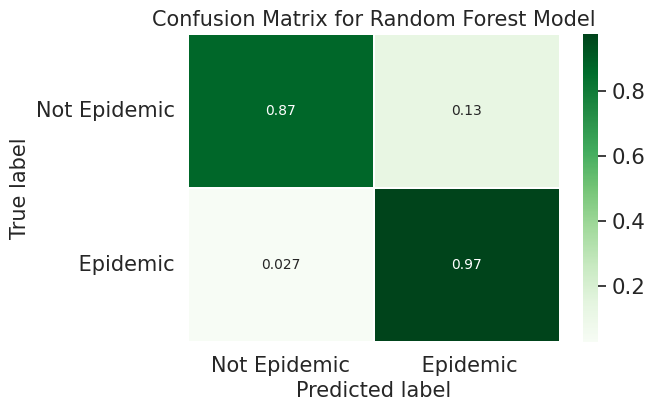

In [ ]:
print('Accuracy score:',accuracy_score(test_labels,predictions))
print('Confusion matrix:',confusion_matrix(test_labels, predictions))
matrix = confusion_matrix(test_labels, predictions)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
print(matrix)


#Plotting the confusion matrix
plt.figure(figsize=(6,4))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['Not Epidemic',' Epidemic']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks+0.5, class_names, rotation=0,fontsize=15)
plt.yticks(tick_marks2, class_names, rotation=0,fontsize=15)
plt.xlabel('Predicted label',fontsize=15)
plt.ylabel('True label',fontsize=15)
plt.title('Confusion Matrix for Random Forest Model',fontsize=15)
plt.show()

In [ ]:
print('Classification report for Random Forest model:\n',classification_report(test_labels,predictions))

Classification report for Random Forest model:
               precision    recall  f1-score   support

           0       0.94      0.87      0.91       583
           1       0.94      0.97      0.96      1203

    accuracy                           0.94      1786
   macro avg       0.94      0.92      0.93      1786
weighted avg       0.94      0.94      0.94      1786



<h2> Logistic Regression </h2>

In [ ]:

logreg = LogisticRegression()
logreg.fit(train_features, train_labels)
pred_log=logreg.predict(test_features)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(test_features,test_labels)))

Accuracy of logistic regression classifier on test set: 0.62


[[  89  494]
 [ 178 1025]]


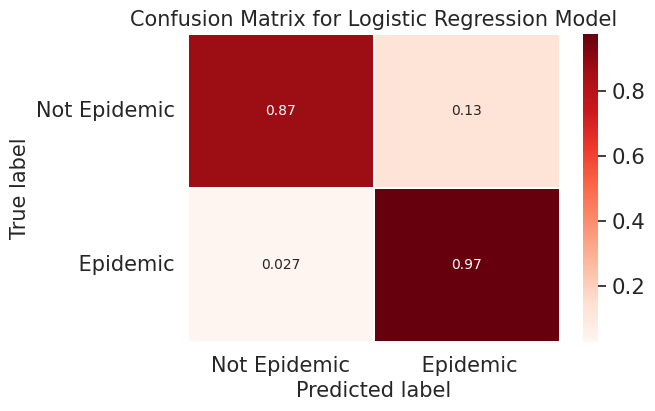

In [ ]:
#Confusion Matrix

confusion_matrix = confusion_matrix(test_labels, pred_log)
print(confusion_matrix)


plt.figure(figsize=(6,4))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Reds, linewidths=0.2)

# Add labels to the plot
class_names = ['Not Epidemic',' Epidemic']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks+0.5, class_names, rotation=0,fontsize=15)
plt.yticks(tick_marks2, class_names, rotation=0,fontsize=15)
plt.xlabel('Predicted label',fontsize=15)
plt.ylabel('True label',fontsize=15)
plt.title('Confusion Matrix for Logistic Regression Model',fontsize=15)
plt.show()

In [ ]:
print('Classification report for Logistic regression model:\n',classification_report(test_labels,predictions))

Classification report for Logistic regression model:
               precision    recall  f1-score   support

           0       0.94      0.87      0.91       583
           1       0.94      0.97      0.96      1203

    accuracy                           0.94      1786
   macro avg       0.94      0.92      0.93      1786
weighted avg       0.94      0.94      0.94      1786



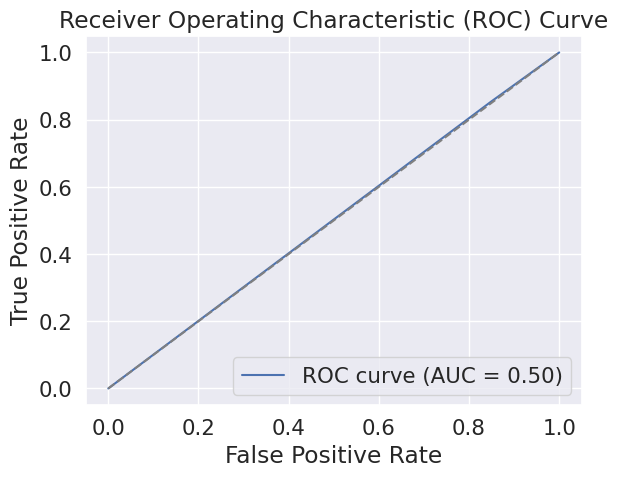

In [ ]:
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(test_labels, pred_log)

# Compute AUC score
auc_score = roc_auc_score(test_labels, pred_log)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(auc_score))
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

[ 0.01097874  0.00037577 -0.09402998  0.00178981  0.06078009 -0.000343
  0.0261125 ]


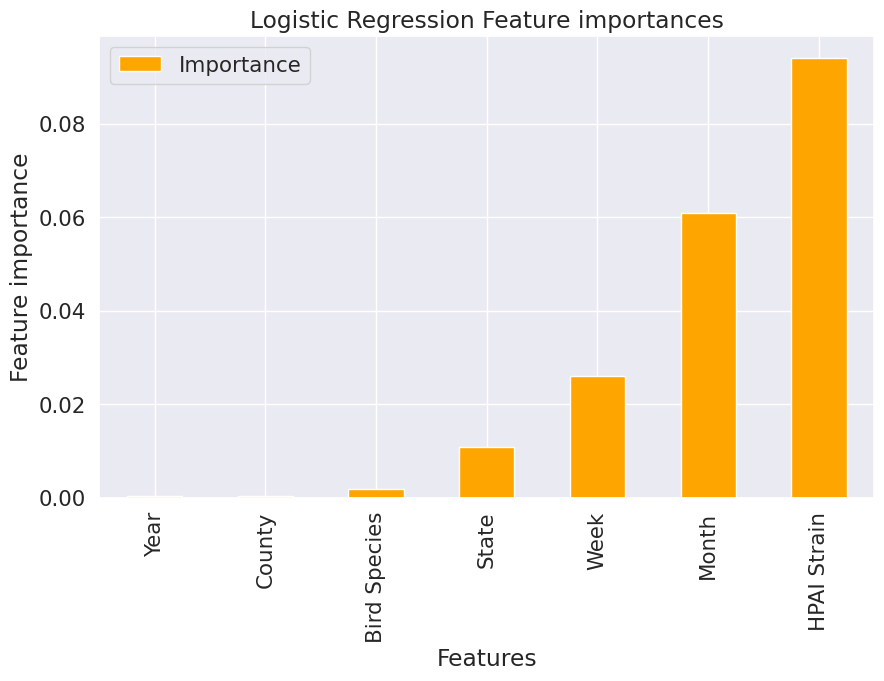

In [ ]:
#Feature importance calculation for logistic regrerssion
coefficients = logreg.coef_[0]
print(coefficients)
feature_importance = pd.DataFrame({'Feature': features.columns, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='bar', figsize=(10, 6),color='orange')
plt.xlabel('Features')
plt.ylabel('Feature importance')
plt.title('Logistic Regression Feature importances')
plt.show()


<h2> Conclusions </h2>

As of the July 2023 running of this notebook, we have found that our models have strong predictive tendencies for detecting avian flu epidemics. Our results support the well-known hypotheses of seasonality and regionality being important indicators for possible avian flu outbreaks.

**Note**: The feature importance for logistic regression model came out to be different than the other two cases. That can be understood as logoistic regression is basically a linear fit to the data. Since it is a simple model, it cannot handle all the complexities  of multi-feature data and at best only tries to order the features by the highest likelihood of observed data.

The best performing model according to accuracy was the random forest classifier followed by the SMC and the logistic regression. This makes sense as the random forest works by classifying the target labels employing multiple decision trees. On the other hand, the logistic regression takes very simple input parameters to come up with the classification predictive algorithm which might not be reliable for a multi-variate dataset like ours. While the SVM classifier model is effective in high dimensional space and robust against overfitting, like logistic regression, it also has difficulty with multi-variate classifiation. However, even with these weaknesses, all of the models accurately predicted epidemics significantly more than half of the time as of July 2023.

The random forest models provide the best predictor of avian flu epidemics. The support vectors machine model provides a solid prediction as well. However with such a small dataset (only 1.5 years of data as of July 2023), it is possible these models are overfit and their accuracy may change over time. With the addition of supplemental data, the performance of the models will likely improve as overfitting will be avoided and the number of false positives will decrease.

Given the strengths and weaknesses of each of these models, along with the relatively short run time of the notebook, we suggest that examining the predictions from all three models in conjunction may be the most useful when determining whether an avian flu epidemic is imminent.